<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План работы</a></span></li><li><span><a href="#Изучение-общей-информации-и-предобработка-данных" data-toc-modified-id="Изучение-общей-информации-и-предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение общей информации и предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

# Выпускной проект

# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 


## Описание данных
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы
- Импортировать данные и провести исследовательский анализ данных.
- Провести предобработку данных.
- Определить и подготовить признаки и выделить целевой.
- Объединить таблицы и удалить ненужные столбцы.
- Исследовать модели (CatBoost, LightGBM, LogisticRegression) и определить лучшую, подбирая гиперпараметры и рассматривая метрику ROC-AUC.
- Проверить модель на тестовой выборке.
- Подготовить отчет.

## Изучение общей информации и предобработка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [ ]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [ ]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

В таблице *contract* 7043 строк, 8 столбцов и нет пропущенных значений. В столбце *Type* три типа контракта: месячный, годичный и двухгодичный, в столбце *PaymentMethod* четыре варианта оплаты: электронный чек, чек по почте, банковский перевод (автоматический) и кредитная карта (автоматический).

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [ ]:
contract['NotClient'] = (contract['EndDate'] != 'No').astype(int) #добавили столбец, показывающий активный клиент или нет

In [ ]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'].replace(['No'], ['2020-02-01']))

In [ ]:
contract['Lifetime'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


Тип данных в столбце *BeginDate* был преобразован в формат *datetime*, а столбец *EndDate* содержит целевой признак, значение *No* в столбце означает, что контракт действующий.

Создали столбец *NotClient* с целевым признаком, который показывает, является ли клиент активным или нет (1 - не клиент, 0 - клиент). Также был создан столбец *Lifetime*, показывающий период использования услуг в днях.

Чтобы избежать утечку данных, удалим столбцы с датами.

In [ ]:
contract = contract.drop(['BeginDate','EndDate'], axis=1)

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors ='coerce')

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
NotClient           7043 non-null int64
Lifetime            7043 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


In [ ]:
contract.isnull().sum()

customerID           0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
NotClient            0
Lifetime             0
dtype: int64

In [ ]:
contract[contract['TotalCharges'].isnull()] #проверяем NaN значения столбца TotalCharges

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Lifetime
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,0,0


Пропуски в столбце *TotalCharges* появились у тех клиентов, кто подключился к услугам 01-02-2020.

In [ ]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0) #заполнили NaN значения нулями

In [ ]:
contract.isnull().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
NotClient           0
Lifetime            0
dtype: int64

In [ ]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal = personal.rename(columns={'gender':'Gender'})

In [ ]:
personal.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
data = contract.merge(personal, 
                      how='left', on='customerID').merge(internet, 
                      how='left', on='customerID').merge(phone, 
                      how='left', on='customerID') 

In [ ]:
data.duplicated().sum()

0

In [ ]:
data = data.set_index('customerID')

In [ ]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,NotClient,Lifetime,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
NotClient           7043 non-null int64
Lifetime            7043 non-null int64
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 1.1+ MB


В столбцах *InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines* есть пропуски, заменим их на *No*.  

In [ ]:
data = data.fillna('No')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
NotClient           7043 non-null int64
Lifetime            7043 non-null int64
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 1.1+ MB


## Исследовательский анализ

In [ ]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Lifetime']

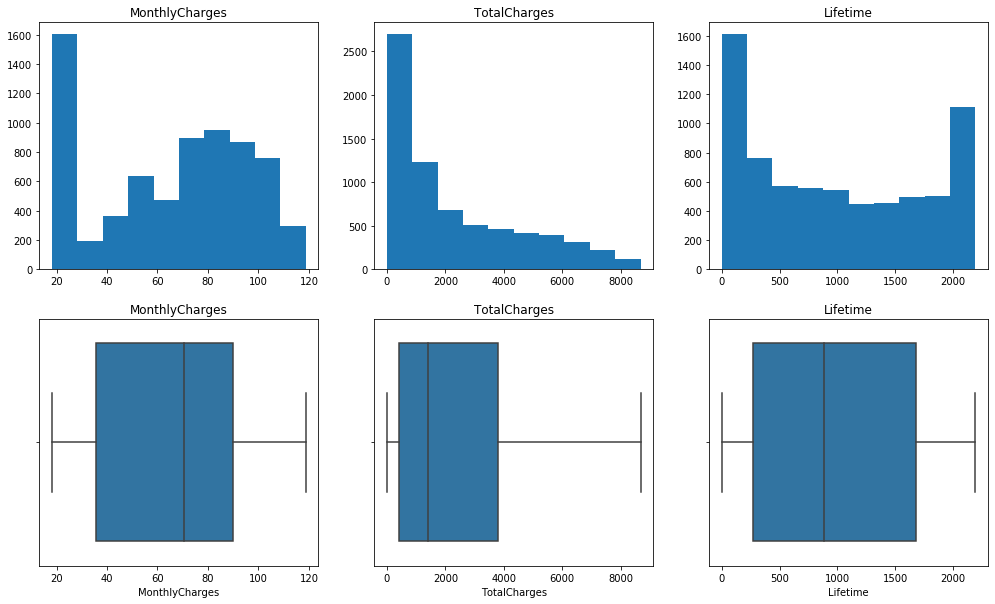

In [ ]:
columns = 3
rows = 2
plt.figure(figsize=(17,10))
num = 0
for column in numeric:
    num += 1
    plt.subplot(rows, columns, num)
    plt.hist(data[column])
    plt.title(column)
    

for column in numeric:
    num += 1
    plt.subplot(rows, columns, num)
    sns.boxplot(data[column])
    plt.title(column)

In [ ]:
categorical = ['Type', 'PaperlessBilling', 'PaymentMethod',
                 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

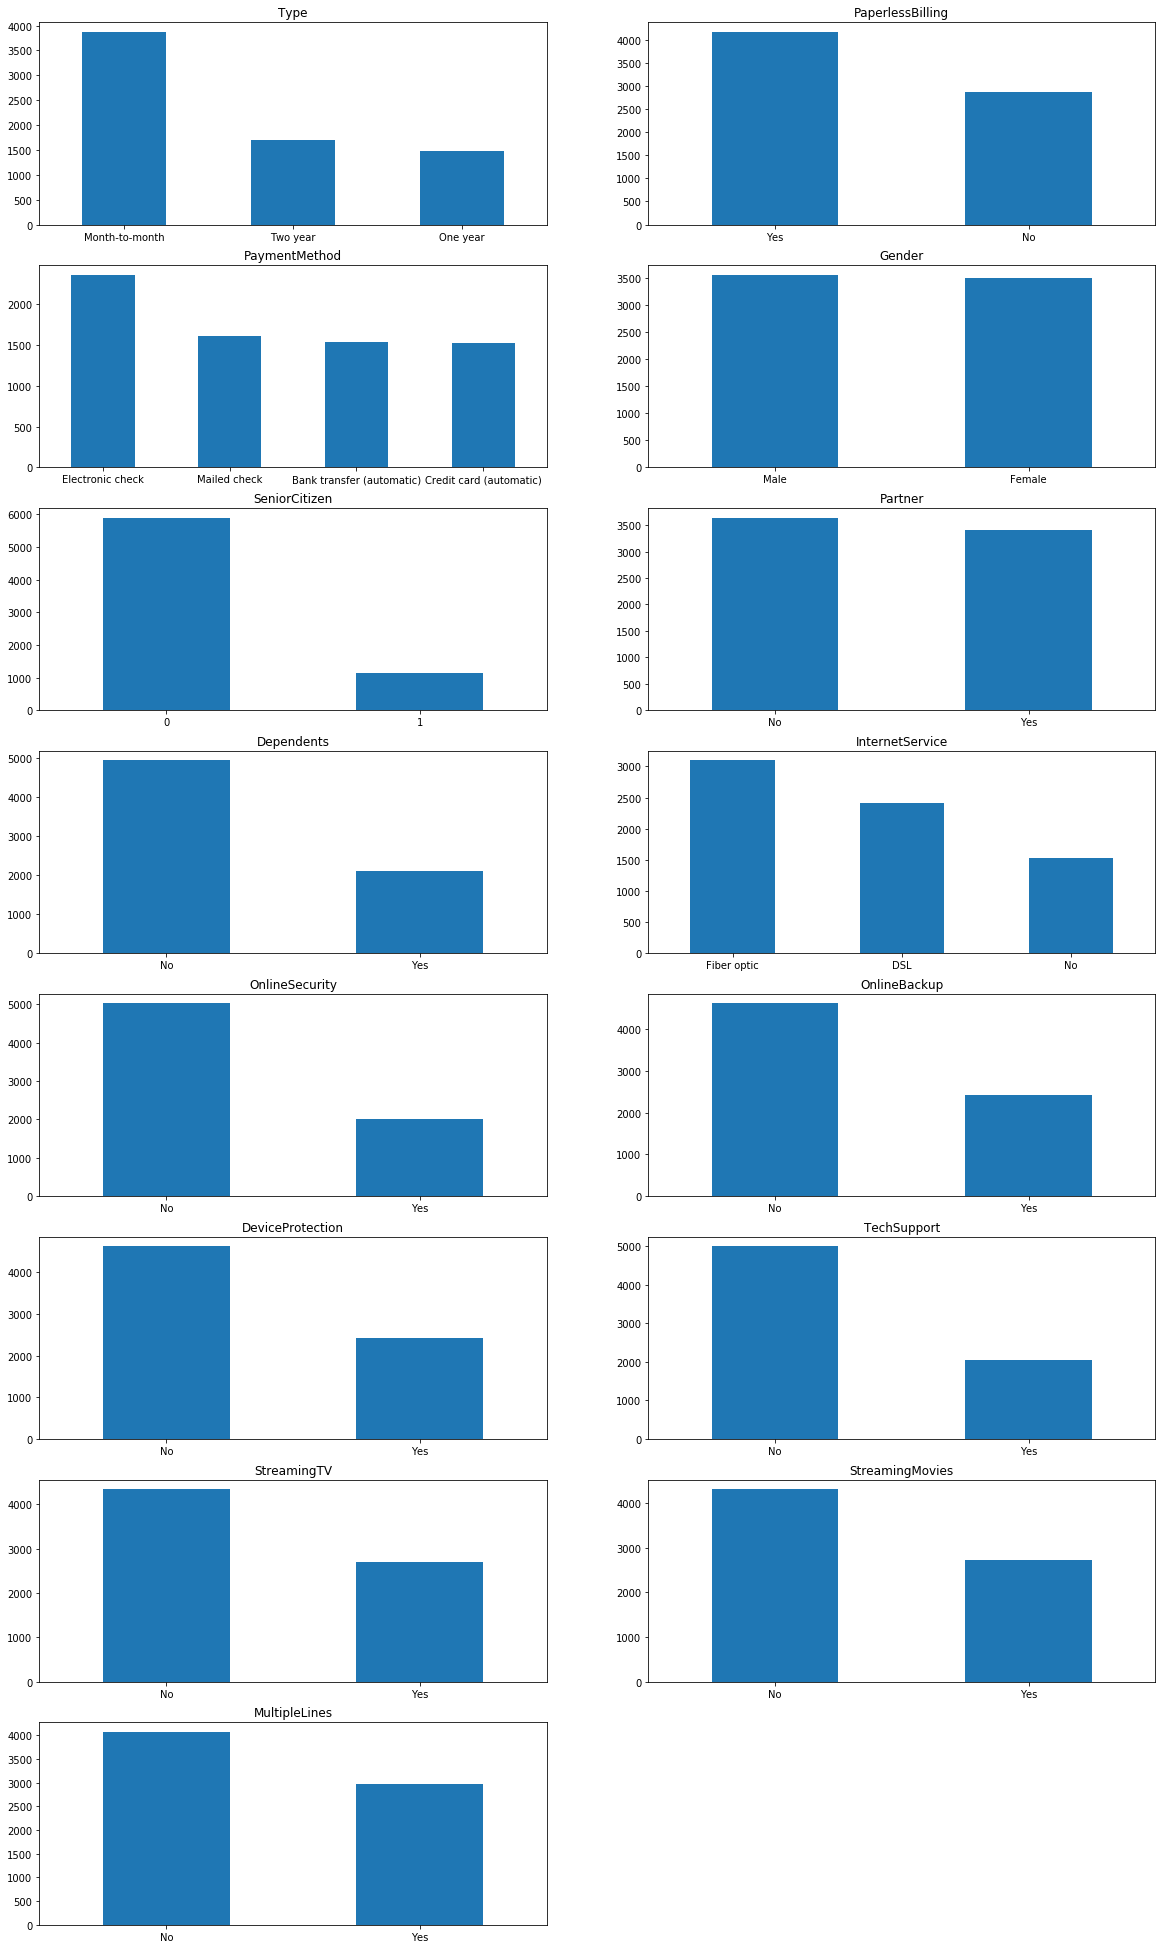

In [ ]:
columns=2
rows = 8

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorical):
    ax = plt.subplot(rows, columns, idx + 1)
    
    data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

Проверим количественные признаки на корреляцию:

In [ ]:
data[numeric].corr()

,MonthlyCharges,TotalCharges,Lifetime
MonthlyCharges,1.000000,0.651174,0.247754
TotalCharges,0.651174,1.000000,0.826109
Lifetime,0.247754,0.826109,1.000000


Между признаками *TotalCharges* и *Lifetime* сильная корреляция, 0.82, присутствует проблему мультиколлинеарности. Это объясняется тем, что чем дольше клиент пользуется услугами, тем больше составляют его общие расходы.

Удалим признак *TotalCharges*.

In [ ]:
data = data.drop('TotalCharges', 1)

In [ ]:
numeric = ['MonthlyCharges', 'Lifetime']

## Подготовка признаков

Модели CatBoost и LightGBM работают с категориальными данными, только для модели LightGBM приведем категориальные признаки к формату category. Для LogisticRegression преобразуем признаки техникой One-Hot Encoding и стандартизируем их.

In [ ]:
target = data['NotClient']
features = data.drop('NotClient', axis=1)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [ ]:
target_ohe = data_ohe['NotClient']
features_ohe = data_ohe.drop('NotClient', axis=1)

In [ ]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=12345)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_train_ohe, target_train_ohe, test_size=0.25, random_state=12345)

Так как у признаков разный масштаб, приведем их к одному масштабу с помощью стандартизации данных.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric]) 
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) 

Проверим баланс классов:

0    0.73463
1    0.26537
Name: NotClient, dtype: float64


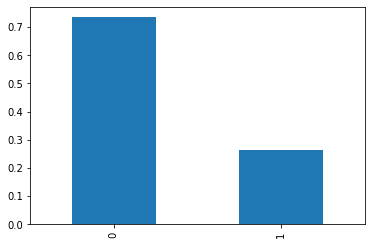

In [ ]:
class_frequency = data_ohe['NotClient'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

Из графика видим, что присутствует дисбаланс классов, соотношение 74% на 26%. Используем метод по взвешиванию классов для устранения дисбаланса, используем аргумент *class_weight* при обучении.

## Обучение моделей

Рассмотрим модели CatBoostClassifier, LGBMClassifier и LogisticRegression.

**CatBoost**

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9] }

model = CatBoostClassifier(random_state=12345, verbose=False, class_weights = [0.73463,0.26537], cat_features=categorical)

cat = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
cat.fit(features_train, target_train)

predictions_valid = cat.predict(features_valid)
probabilities_valid = cat.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
accuracy = accuracy_score(target_valid, predictions_valid)

print(cat.best_params_)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

{'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
ROC-AUC: 0.8781041063606322
Accuracy: 0.8204400283889283


**LightGBM**

In [ ]:
features_train[categorical] = features_train[categorical].astype('category')
features_valid[categorical] = features_valid[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

In [ ]:
param_grid = {'num_leaves':[20,40,60,80,100], 
              'max_depth':[5,10,20],
              'learning_rate':[0.1,0.3],
              'reg_alpha':[0,0.01,0.03]}

model = LGBMClassifier(random_state=12345, class_weight = 'balanced')

lgbm = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
lgbm.fit(features_train, target_train)

predictions_valid = lgbm.predict(features_valid)
probabilities_valid = lgbm.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
accuracy = accuracy_score(target_valid, predictions_valid)

print(lgbm.best_params_)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

{'learning_rate': 0.3, 'max_depth': 5, 'num_leaves': 20, 'reg_alpha': 0.03}
ROC-AUC: 0.8968401772677205
Accuracy: 0.829666430092264


**LogisticRegression**

In [ ]:
param_grid = {'C': [0.1,1,10,100],
     'solver':['liblinear', 'lbfgs'],
     'max_iter':[100,500]}

model = LogisticRegression(random_state=12345, class_weight='balanced')

lr = GridSearchCV(model, param_grid, scoring = 'roc_auc', cv = 5)
lr.fit(features_train_ohe, target_train_ohe)

predictions_valid = lr.predict(features_valid_ohe)
probabilities_valid = lr.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid)
accuracy = accuracy_score(target_valid_ohe, predictions_valid)

print(lr.best_params_)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

{'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
ROC-AUC: 0.8968401772677205
Accuracy: 0.7551454932576295


Лучший результат получили на модели LightGBM:
- ROC-AUC = 0.897
- Accuracy = 0.830

## Анализ моделей 

Проверим модели на тестовой выборке.

**CatBoost**

In [ ]:
predictions_test = cat.predict(features_test)
probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predictions_test)

print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

ROC-AUC: 0.868607283887029
Accuracy: 0.8232789212207239


**LightGBM**

In [ ]:
predictions_test = lgbm.predict(features_test)
probabilities_test = lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predictions_test)

print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

ROC-AUC: 0.8882119709846338
Accuracy: 0.8261178140525195


**LogisticRegression**

In [ ]:
predictions_test = lr.predict(features_test_ohe)
probabilities_test = lr.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:, 1]

roc_auc = roc_auc_score(target_test_ohe, probabilities_one_test)
accuracy = accuracy_score(target_test_ohe, predictions_test)

print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

ROC-AUC: 0.8240983668126018
Accuracy: 0.7409510290986515


Лучший результат подтвердила модель LightGBM с результатом *ROC-AUC = 0.888* и *accuracy = 0.826*

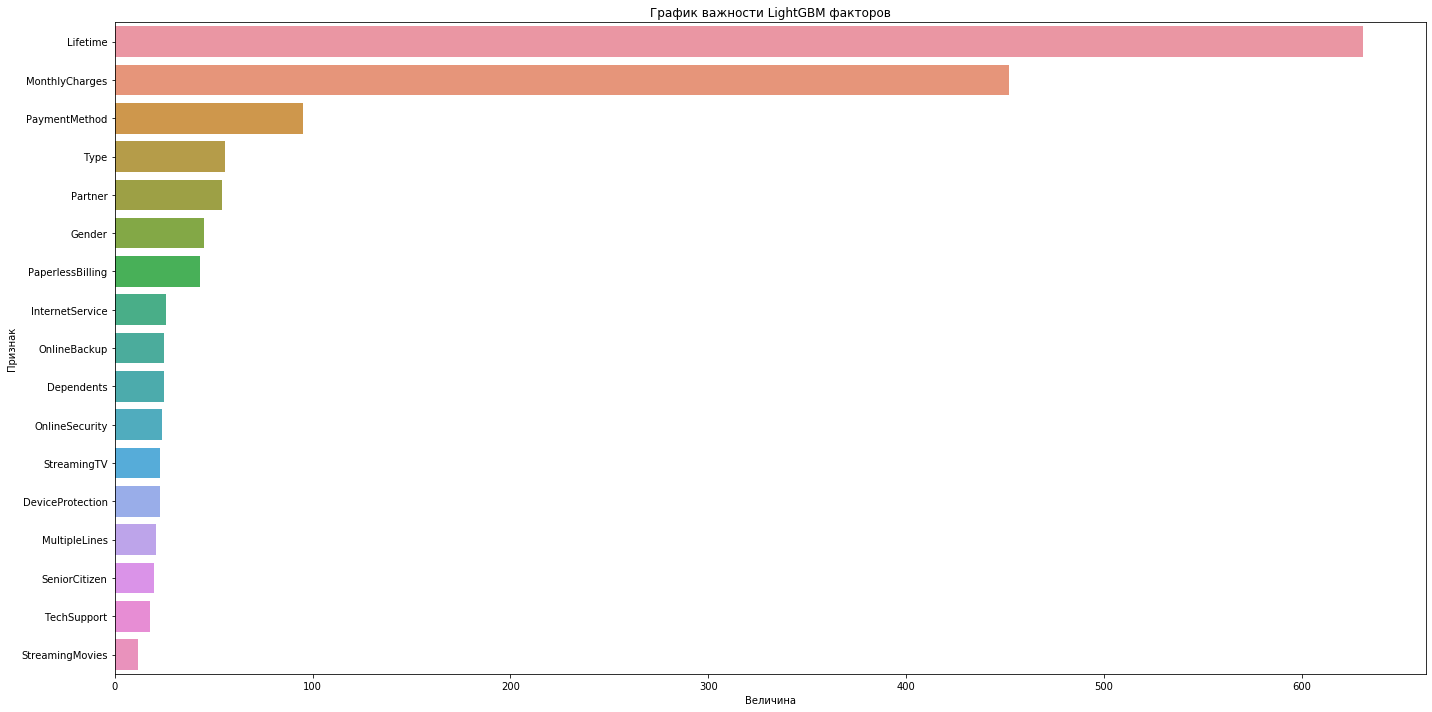

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.best_estimator_.feature_importances_, features_test.columns)), 
                           columns=['Величина','Признак'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Величина", y="Признак", data=feature_imp.sort_values(by="Величина", ascending=False))
plt.title('График важности LightGBM факторов')
plt.tight_layout()
plt.show()

**Вывод:**

В данном проекте было необходимо создать модель для прогнозирования оттока клиентов. Были выполнены все пункты плана: 
- Импортированы данные.
- Проведен исследовательский анализ данных.
- Проведена предобработка данных.
- Определены и подготовлены признаки, найден целевой.
- Объединены таблицы и удалены ненужные столбцы с проверкой на корреляцию.
- Исследованы три модели (CatBoost, LightGBM, LogisticRegression).
- Определена лучшая модель с использованием GridSearchCV для подбора гиперпараметров и изучением метрики ROC-AUC.
- Модель проверена на тестовой выборке.


Ключевыми шагами в решении являлись предобработка данных и исследовательский анализ, так как от них зависит качество модели. Необходимо было определить, какие признаки являются важными, а какие можно удалить, опираясь на результаты корреляции, чтобы избежать утечки данных. Также важным шагом являлся подбор гиперпараметров моделей для получения необходимой метрики.

Самый лучший результат показала модель LightGBM: 
- ROC-AUC = 0.888 (тест)
- Accuracy = 0.826 (тест)